# EDA

EDA of the features and target

# Goal

Find patterns on the features for target

# Plan

Checklist what will be done on the notebook :

    [ ] Get Data
    [ ] Data Preparations
    [ ] Features Summary
    [ ] Features correlations to Target



In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_UDF = config['path']['udf']

In [3]:
# %matplotlib inline

## Get Data

In [4]:
raw_trn = pd.read_csv(PATH_INTERIM+'data_trn_iter2.csv')

In [5]:
train_ids = raw_trn.sample(int(len(raw_trn)*0.85), random_state = 124)['ids']
raw_trn['is_train'] = raw_trn['ids'].isin(train_ids).astype(int)

In [6]:
## check target
raw_trn[raw_trn.is_train == 1]['y'].value_counts(normalize = True)

no     0.884525
yes    0.115475
Name: y, dtype: float64

## Data Preparation
source : [link](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#ch5)

Creating
Cleaning
Combining
Completing
Creating
Converting

In [7]:
raw_trn.head()

,ids,age,balance,day,duration,pdays,job,contact,education,marital,default,y,is_train
0,0,58,2143,5,261,-1,management,unknown,tertiary,married,no,no,1
1,2,33,2,5,76,-1,entrepreneur,unknown,secondary,married,no,no,1
2,3,47,1506,5,92,-1,blue-collar,unknown,unknown,married,no,no,1
3,5,35,231,5,139,-1,management,unknown,tertiary,married,no,no,1
4,6,28,447,5,217,-1,management,unknown,tertiary,single,no,no,1


In [8]:
raw_trn['y2'] = (raw_trn['y'] == 'yes').astype(int)

In [9]:
## separate the columns
col_num = ['age','balance','day',
                      'duration','pdays']
col_cat = ['job','contact','marital','default','education']

#### Missing Value

In [10]:
raw_trn.sample(10)

,ids,age,balance,day,duration,pdays,job,contact,education,marital,default,y,is_train,y2
6727,7924,36,71,30,510,-1,blue-collar,unknown,secondary,married,no,no,1,0
31905,37527,32,-446,13,126,344,blue-collar,cellular,secondary,married,no,no,1,0
25345,29839,36,372,4,94,-1,services,cellular,secondary,married,no,no,1,0
30991,36449,35,151,11,301,298,blue-collar,cellular,primary,married,no,no,1,0
657,763,30,800,6,95,-1,self-employed,unknown,tertiary,single,no,no,1,0
31460,37001,47,10558,13,81,174,blue-collar,cellular,primary,single,no,no,1,0
34854,40979,60,523,13,192,-1,retired,cellular,secondary,married,no,yes,1,1
16668,19631,60,6557,7,214,-1,services,cellular,tertiary,married,no,no,1,0
25571,30106,36,313,4,403,-1,admin.,telephone,secondary,married,no,no,1,0
10674,12553,44,303,3,51,-1,technician,unknown,secondary,divorced,no,no,1,0


In [11]:
raw_trn.isnull().sum()

ids          0
age          0
balance      0
day          0
duration     0
pdays        0
job          0
contact      0
education    0
marital      0
default      0
y            0
is_train     0
y2           0
dtype: int64

#### Outliers

In [12]:
## Numerical
df_num = raw_trn[col_num+['is_train']]

In [13]:
## only check on training
df_num[df_num.is_train == 1].describe()

,age,balance,day,duration,pdays,is_train
count,32665.000000,32665.000000,32665.000000,32665.000000,32665.000000,32665.0
mean,40.923435,1348.657676,15.798990,256.926527,40.400827,1.0
std,10.587586,3069.857375,8.308533,256.887782,100.816634,0.0
min,18.000000,-8019.000000,1.000000,0.000000,-1.000000,1.0
25%,33.000000,69.000000,8.000000,103.000000,-1.000000,1.0
50%,39.000000,442.000000,16.000000,179.000000,-1.000000,1.0
75%,48.000000,1415.000000,21.000000,317.000000,-1.000000,1.0
max,95.000000,102127.000000,31.000000,4918.000000,871.000000,1.0


In [14]:
## Cap the data

In [15]:
df_num[df_num.is_train == 1].quantile(0.98).to_dict()

{'age': 63.0,
 'balance': 9328.160000000003,
 'day': 30.0,
 'duration': 1044.0,
 'pdays': 361.0,
 'is_train': 1.0}

In [16]:
rule_cap = df_num[df_num.is_train == 1].quantile(0.98).to_dict()
joblib.dump(rule_cap, PATH_MODEL+'outliers_cap_rules.pkl')
rule_cap_load = joblib.load(PATH_MODEL+'outliers_cap_rules.pkl')

In [17]:
raw_trn['balance2'] = np.where(raw_trn['balance']<0,0, raw_trn['balance'])
col_num2 = []

for c2 in col_num:
    if c2 == 'balance':
        ck = c2+'2'
    else:
        ck = c2
    max_cap = rule_cap_load[c2]
    raw_trn[ck+'_cap'] = np.where(raw_trn[ck] >= max_cap, max_cap, raw_trn[ck])
    
    col_num2.append(ck+'_cap')

In [18]:
## check pdays
# df_num['pdays'].value_counts(normalize = True) --> 80% is -1

raw_trn['is_contacted'] = (raw_trn['pdays'] != -1).astype(int)


In [19]:
## Categoric
df_cat = raw_trn[col_cat+['is_train']]

In [20]:
# for c in col_cat:
#     print('***',c,'***')
#     print(df_cat[c].value_counts(normalize = True))
#     print('---')

In [21]:
col_cat += ['is_contacted']
col_cat = list(set(col_cat))

#### EDA & Feature engineering

##### Numeric

-- there is a scatter matrix / pairplot

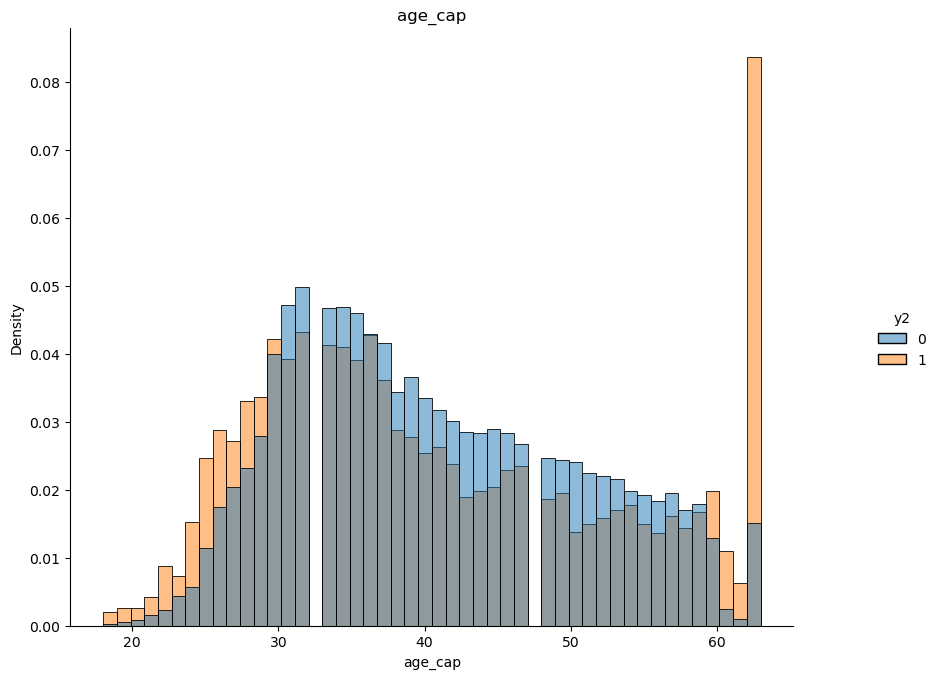

<Figure size 640x480 with 0 Axes>

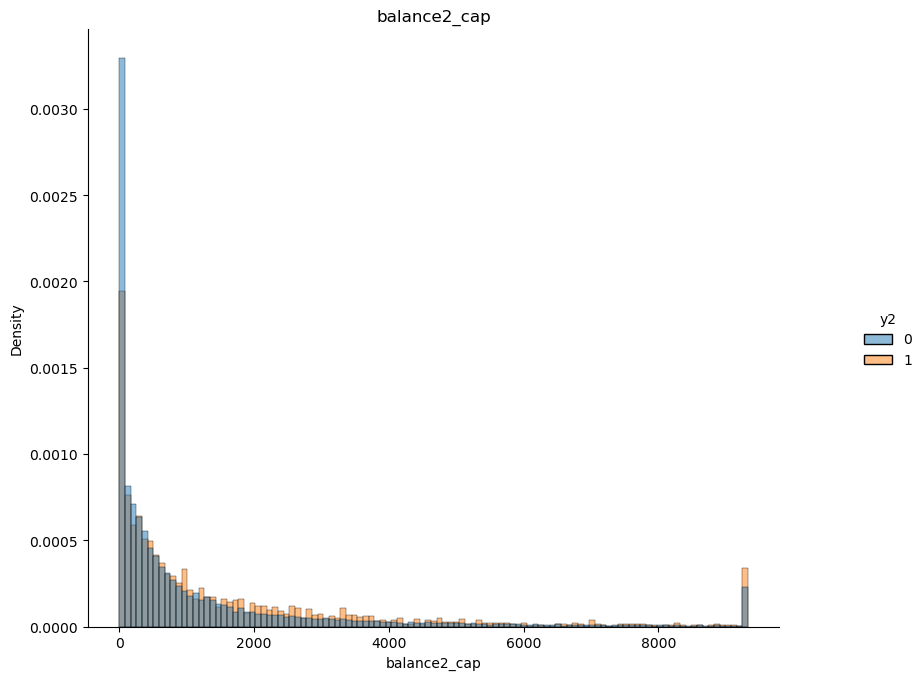

<Figure size 640x480 with 0 Axes>

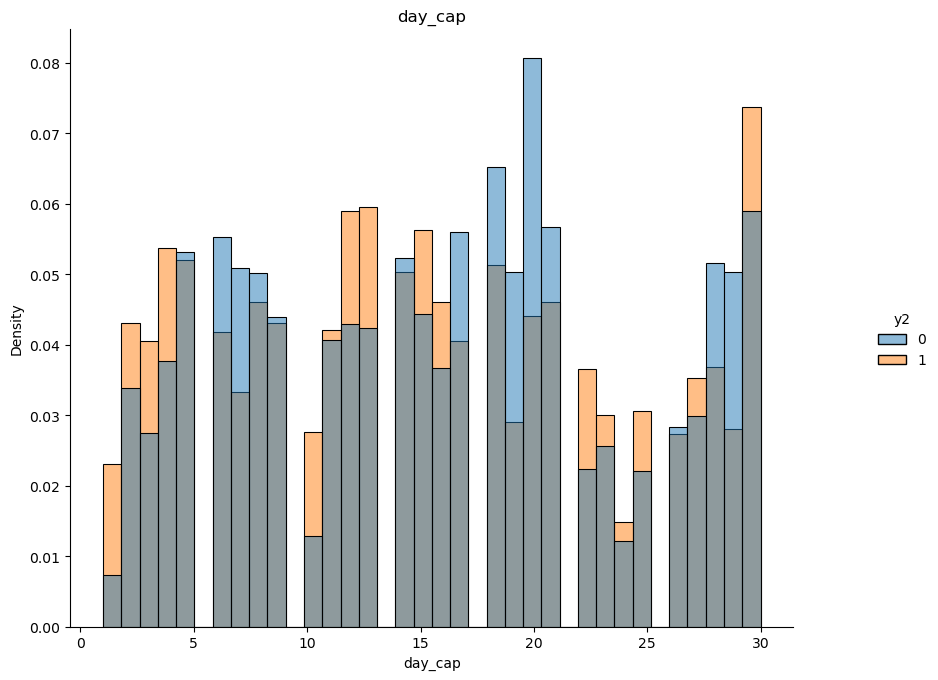

<Figure size 640x480 with 0 Axes>

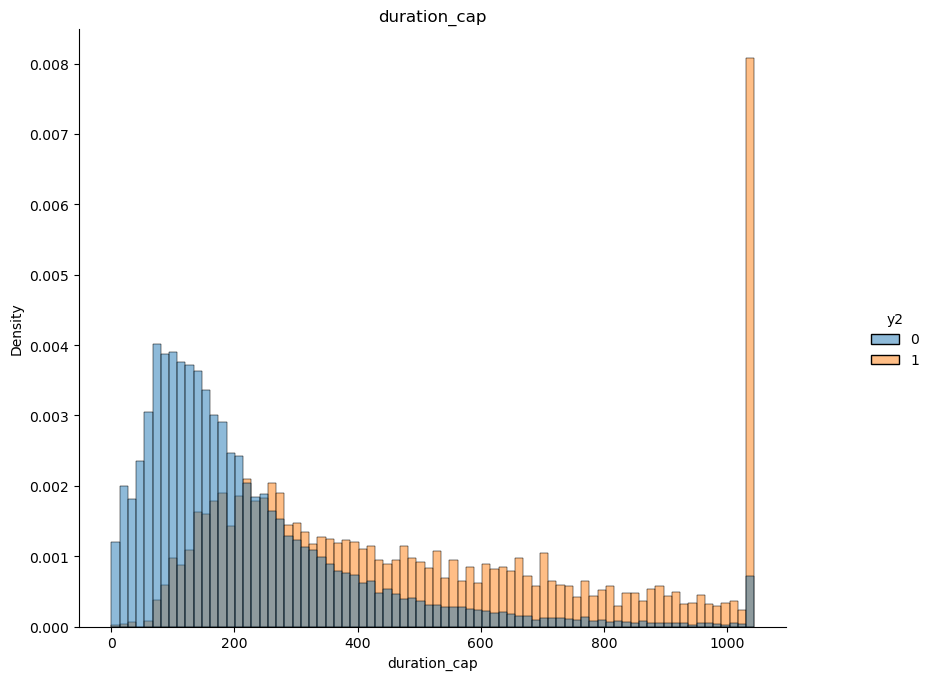

<Figure size 640x480 with 0 Axes>

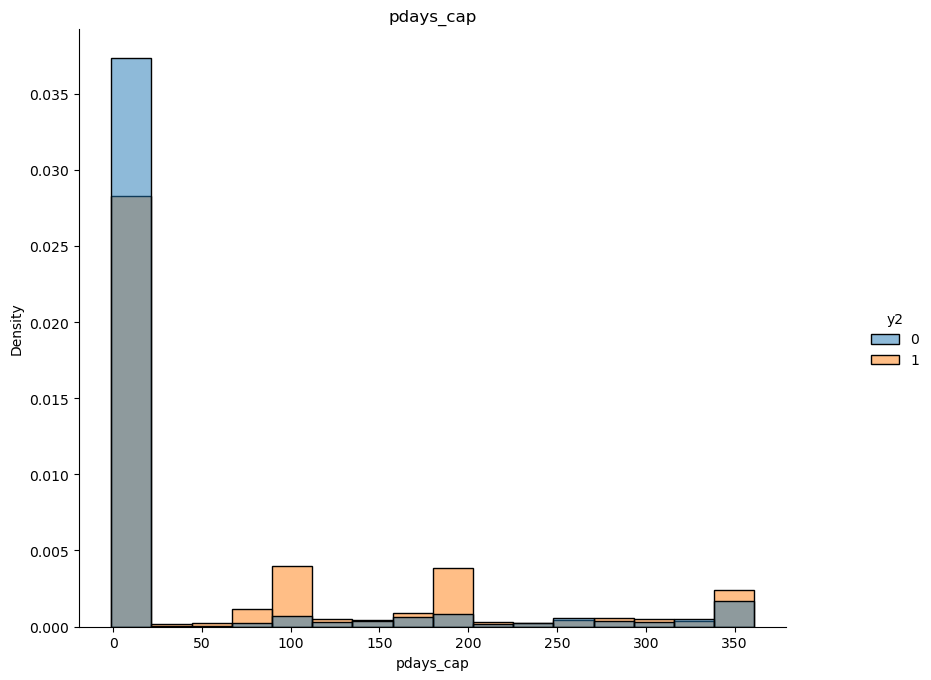

In [22]:
target = 'y2'
c = 'age'
for c in col_num2:
    sns.displot(data = raw_trn[raw_trn.is_train == 1], 
            x = c, 
            hue = target,
            stat="density", common_norm=False)
    plt.gcf().set_size_inches(10, 7)
    plt.title(c)
    plt.show()
    plt.clf()

<Figure size 640x480 with 0 Axes>

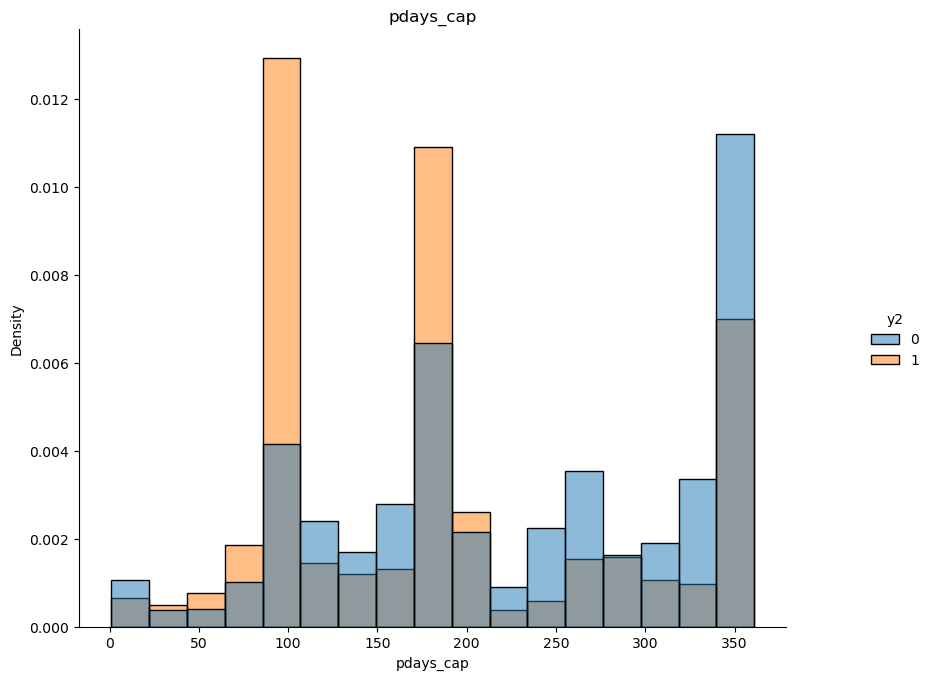

In [23]:
sns.displot(data = raw_trn[(raw_trn.is_train == 1)&(raw_trn.pdays_cap!=-1)], 
            x = 'pdays_cap', 
            hue = target,
            stat="density", common_norm=False)
plt.gcf().set_size_inches(10, 7)
plt.title(c)
plt.show()
plt.clf()

Numeric Exploration Takeaway :

1. age :less than 30 or more than 60 is more likely to Yes,  otherwise more likely to No
2. balance and day : There is no huge evidence of pattern
3. duration : higher duration, higher probability to Yes
4. pdays : no particular pattern

##### Categoric

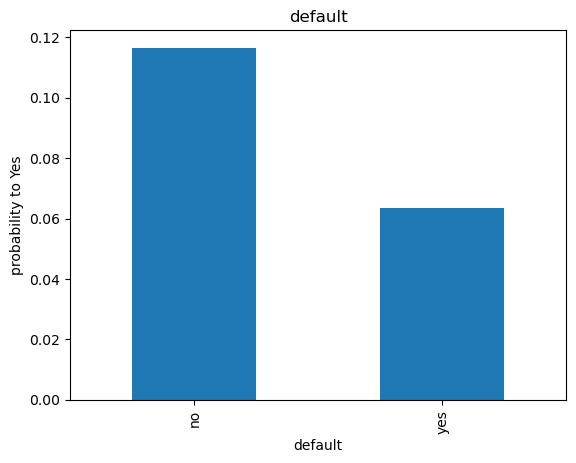

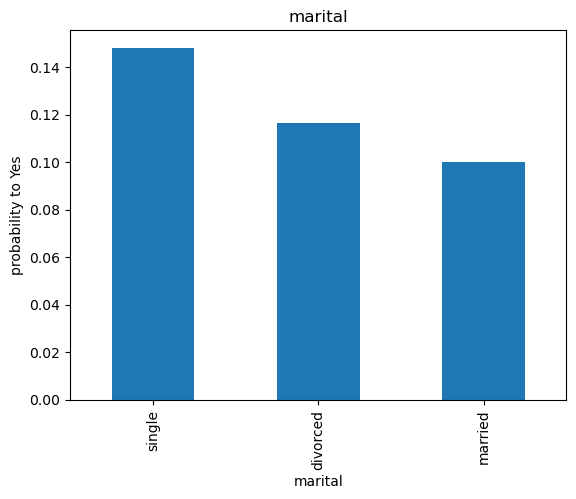

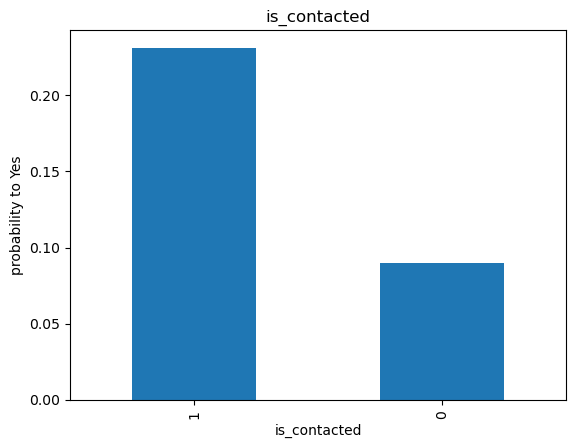

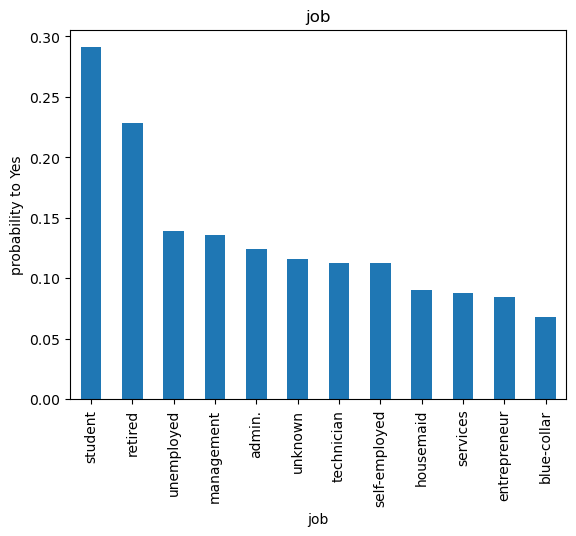

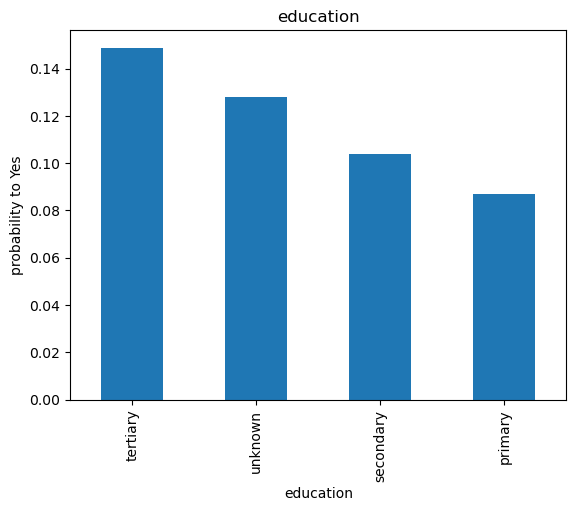

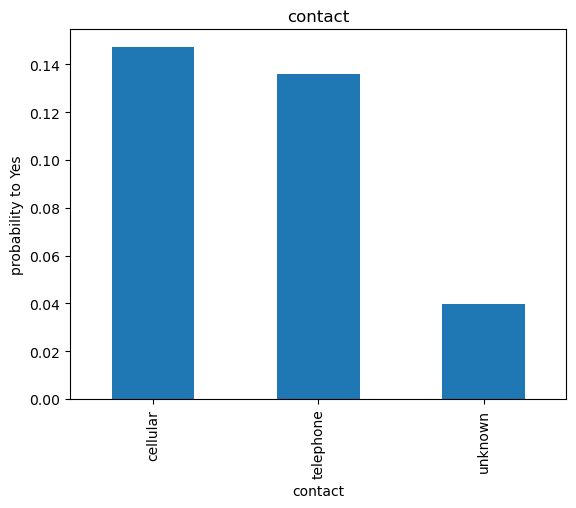

In [32]:
target = 'y2'
c = 'marital'
for c in col_cat:
    # mosaic(raw_trn[raw_trn.is_train == 1], [c, target], title=c)
    # plt.show()
    raw_trn[raw_trn.is_train == 1].groupby(c)[target].mean().sort_values(ascending=False).plot(kind = 'bar',title = c)
    plt.ylabel('probability to Yes')
    plt.show()


Numeric Exploration Takeaway :

1. default : slightly differences between entity
2. marital : single has slightly higher probability to Yes
3. is_contacted : higher prob if the back contact the user
4. job : we can grouping service, housemaid, entrepreneur (and self-employed), blue-collar as same group. Also admin, unknown, technician as same group.
5. education : slightly differences
6. contact :  may same as is_contacted

In [51]:
## further exploration on Job
jgroup1 = ['services', 'self-employed', 'entrepreneur', 'housemaid']
jgroup2 = ['admin.', 'technician', 'unknown']
raw_trn['job2'] = raw_trn['job'].apply(lambda x : np.where(x in jgroup1,'jgr1',
                                                        np.where(x in jgroup2,'jgr2',x)))
## --> unrecognize job in the future will refer as jgr2

In [52]:
raw_trn[raw_trn.is_train==1][['job','job2']].value_counts(normalize=True)

job            job2       
blue-collar    blue-collar    0.214633
management     management     0.207898
technician     jgr2           0.168590
admin.         jgr2           0.115139
services       jgr1           0.092821
retired        retired        0.049043
self-employed  jgr1           0.035696
entrepreneur   jgr1           0.032940
unemployed     unemployed     0.028379
housemaid      jgr1           0.027797
student        student        0.020726
unknown        jgr2           0.006337
dtype: float64

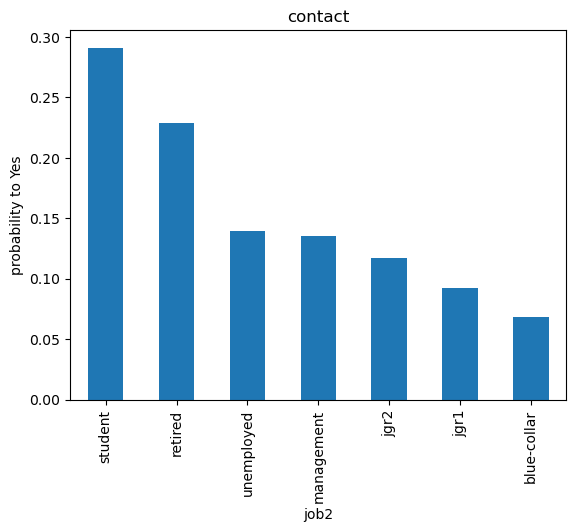

In [53]:
raw_trn[raw_trn.is_train == 1].groupby('job2')[target].mean().sort_values(ascending=False).plot(kind = 'bar',title = c)
plt.ylabel('probability to Yes')
plt.show()

In [56]:
## further exploration on Job
raw_trn.groupby(['contact','is_contacted']).size().unstack()

## how the user have contact type but never have been contacted before

is_contacted,0,1
contact,,
cellular,18440,6393
telephone,1972,539
unknown,11026,60


#### Features Selection

## Conclusions